# O consumo de energia elétrica de casa

## Resumo

O consumo de energia durante a pandemia possivelmente reduziu em comparação a 2018 e 2019. Por causa dos aumentos nas tarifas de energia, o consumo do mês de Dezembro deve ser de 367 kWh para compensar a bandeira de escassez hídrica e pagar o mesmo valor de Agosto. Para pagar o mesmo valor de Dezembro de 2020, a meta é consumir 338 kWh.

## Introdução

Com os aumentos nas bandeiras tarifárias e o aperto nas contas de casa, resolvi analisar o consumo de energia com o objetivo de responder duas perguntas:

1. Como se comportou o consumo durante a pandemia? A intuição de que consumimos mais energia durante esse período é verdadeira?
2. Com a mudança de bandeiras tarifárias, como economizar energia para pagar menos? O quanto menos de energia devemos usar em comparação com o consumo usual?

Para responder essas perguntas, coletei e analisei o consumo energético de casa nos últimos 4 anos (38 medidas) usando ferramentas estatísticas em busca de tendências na linha temporal. Além de cruzar-los com os dados fornecidos pela ANEEL. Como ferramenta de trabalho, usei esse caderno de jupyter com núcleo R.

A seguir, a linha temporal completa com os valores de energia em unidades de kWh e valor da conta em R$:

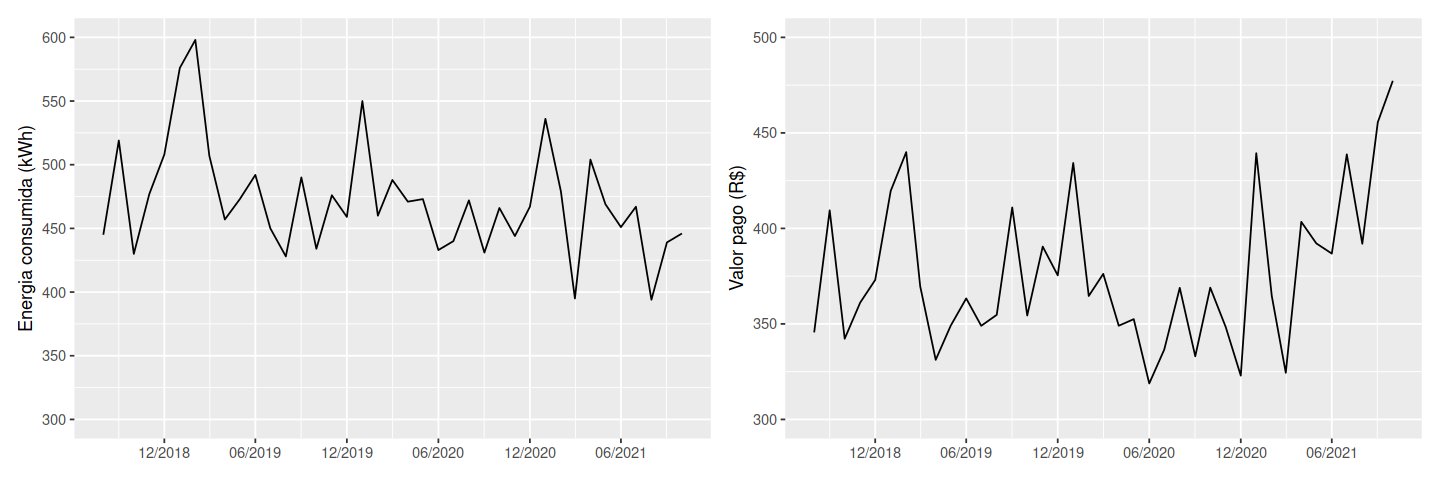

In [32]:
library(dplyr)
library(ggplot2)
library(patchwork)
library(scales)
library(TTR)
options(repr.plot.width = 12, repr.plot.height = 4)

# Importando o CSV com todos os dados durante a série temporal
df <- read.csv("./fontes/consumo_energia.csv") %>%
    mutate(data_referencia = as.Date(data_referencia))

# Energia consumida vs. data de medição
fig1 <- ggplot(df,
        aes(
            x = data_referencia,
            y = energia
        )
    ) +
    geom_line() +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Energia consumida (kWh)",
        breaks = scales::breaks_extended(6),
        limits = c(300, 600)
    )

# Valor pago vs. data de medição
fig2 <- ggplot(df,
        aes(
            x = data_referencia,
            y = valor
        )
    ) +
    geom_line() +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Valor pago (R$)",
        breaks = scales::breaks_extended(5),
        limits = c(300, 500)
    )

fig1 + fig2

Antes de começar qualquer tipo de análise estatística, é importante ressaltar que nem toda medição foi feita no mesmo intervalo de tempo, gerando datas de referência incomparáveis entre si. Por essa razão, busquei normalizar o tempo de medição da seguinte forma: para cada data de referência, obtive um consumo médio diário a partir do número de dias desse período:

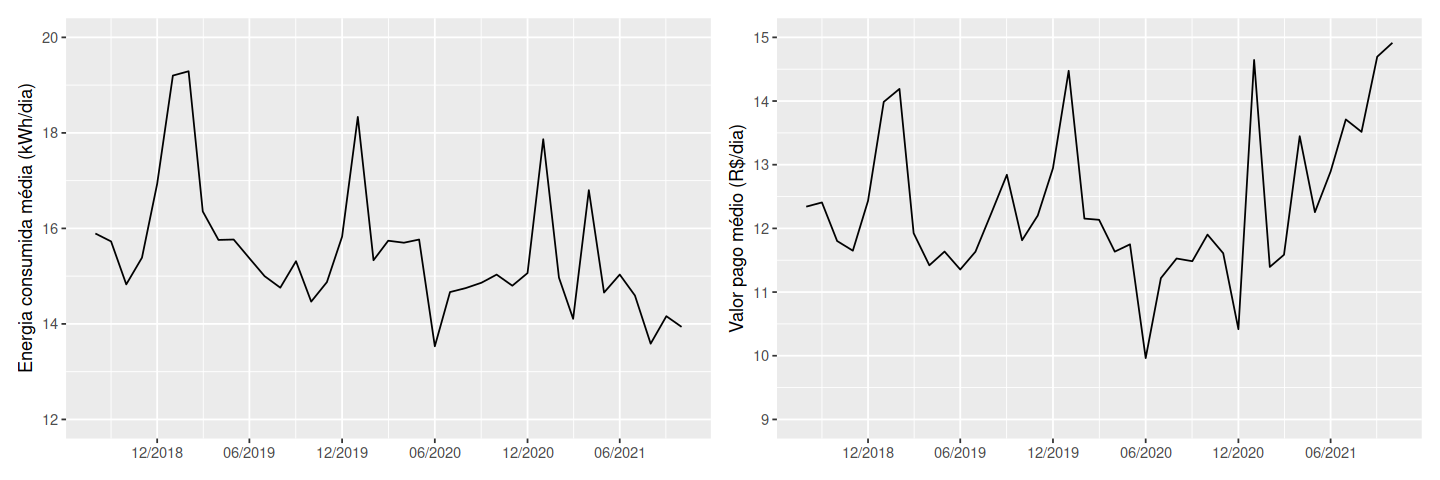

In [33]:
# Adiciona duas colunas novas com as médias temporais
df <- df %>% mutate(
    energia_medio = energia / dias_medidos,
    valor_medio = valor / dias_medidos
)

# Energia consumida vs. data de medição
fig3 <- ggplot(df,
        aes(
            x = data_referencia,
            y = energia_medio
        )
    ) +
    geom_line() +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Energia consumida média (kWh/dia)",
        breaks = scales::breaks_extended(6),
        limits = c(12, 20)
    )

# Valor pago vs. data de medição
fig4 <- ggplot(df,
        aes(
            x = data_referencia,
            y = valor_medio
        )
    ) +
    geom_line() +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Valor pago médio (R$/dia)",
        breaks = scales::breaks_extended(6),
        limits = c(9, 15)
    )

fig3 + fig4

## Como se comportou o consumo durante a pandemia?

Com esses valores médios, então começo a análise exploratória. Primeiramente, é útil verificar a distribuição dos valores médios de consumo energético. O gráfico de violino mostra que, apesar do consumo energético ter distribuição próxima da normal com um ou dois meses de maior consumo, o teste de Shapiro-Wilker confirma que essas não a seguem.


	Shapiro-Wilk normality test

data:  df$energia_medio
W = 0.86759, p-value = 0.0002942


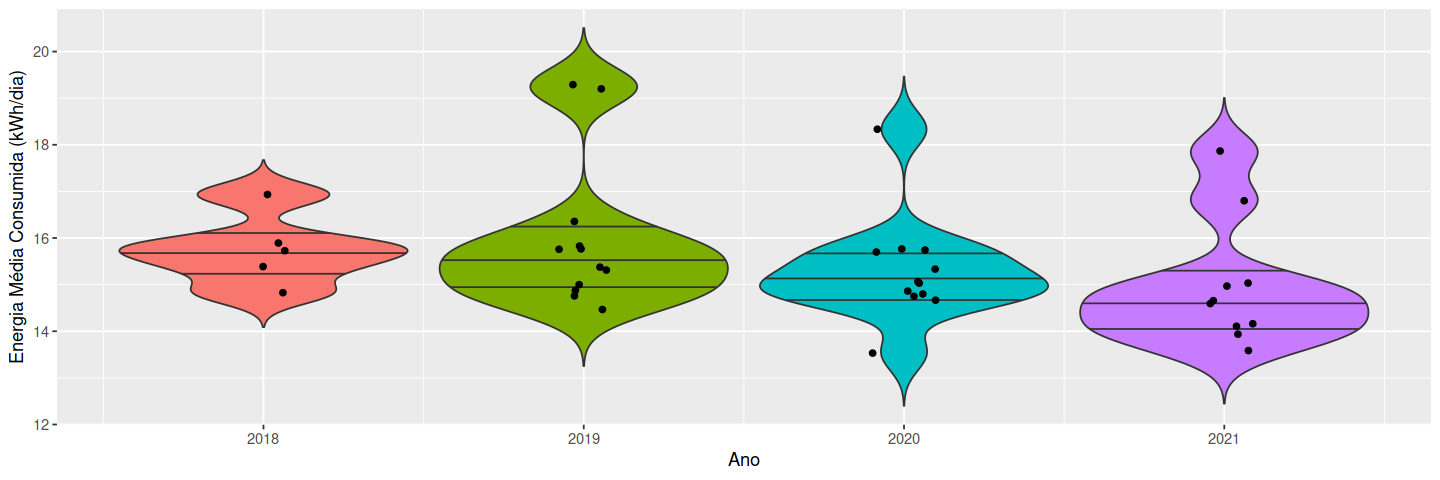

In [34]:
# Como os dados se distribuem? Há ouliers?
ggp_energia <- ggplot(df,
    aes(
        x = as.numeric(format(data_referencia, "%Y")),
        y = energia_medio,
        fill = format(data_referencia, "%Y")
    )
)

ggp_energia + geom_violin(
    draw_quantiles = c(0.25, 0.50, 0.75),
    scale = "width",
    show.legend = FALSE,
    trim = FALSE
    ) +
    labs(
        x = "Ano",
        y = "Energia Média Consumida (kWh/dia)"
    ) +
    geom_jitter(
        height = 0,
        width = 0.1,
        show.legend = FALSE
    )

# Como se compara a variância poderada de cada medição
# com a variância da amostra? A hipótese nula (p > 0,05)
# diz que a distribuição é normal

shapiro.test(df$energia_medio)

Já é possível observar que o consumo energético diminuiu com o passar dos anos, vide tabela. Em 2021, o consumo mediano (até o momento) é 2,8% menor que o do ano anterior, que por sua vez foi 3,3% menor que o consumo de 2019. Apliquei o teste de Kruskal–Wallis para a não-significância dessas diferenças escolhendo $\alpha =$ 0,05. Seu resultado demonstra que não é possível descartar a hipótese nula. A dispersão das medições de consumo energético, ou seja, a alta de consumo nos meses do verão tem influência importante na média anual.

In [56]:
library(xtable)
library(IRdisplay)
library(repr)

options(repr.vector.quote = FALSE)

tabela <- xtable(
    data.frame(
        c("2018", "2019", "2020", "2021"),
        c("15,7±0,8", "15,6±1,6", "15,1±1,1", "14,6±1,4")
    )
)
colnames(tabela) <- c("Ano", "Consumo energético médio (kWh/dia)")
display_html(paste(capture.output(print(tabela, type = 'html')), collapse="", sep=""))

,Ano,Consumo energético médio (kWh/dia)
1,2018,"15,7±0,8"
2,2019,"15,6±1,6"
3,2020,"15,1±1,1"
4,2021,"14,6±1,4"


In [36]:
# Comparação de consumo médio anual
energia_medio_ano <- c(
    median(df$energia_medio[format(df$data_referencia, "%Y") == 2018]),
    median(df$energia_medio[format(df$data_referencia, "%Y") == 2019]),
    median(df$energia_medio[format(df$data_referencia, "%Y") == 2020]),
    median(df$energia_medio[format(df$data_referencia, "%Y") == 2021])
)

energia_medio_sd <- c(
    sd(df$energia_medio[format(df$data_referencia, "%Y") == 2018]),
    sd(df$energia_medio[format(df$data_referencia, "%Y") == 2019]),
    sd(df$energia_medio[format(df$data_referencia, "%Y") == 2020]),
    sd(df$energia_medio[format(df$data_referencia, "%Y") == 2021])
)

delta_energia_mediana <- 100 * (energia_medio_ano / lag(energia_medio_ano) - 1)

# Teste de Kruskal–Wallis para avaliar se há diferença entre os anos
# A hipótese nula (p > 0,05) diz que a mediana de cada ano é idêntica
kruskal.test(
    energia_medio ~ as.numeric(format(data_referencia, "%Y")),
    data = df
)


	Kruskal-Wallis rank sum test

data:  energia_medio by as.numeric(format(data_referencia, "%Y"))
Kruskal-Wallis chi-squared = 6.5902, df = 3, p-value = 0.08617


## O quanto se deve economizar de energia para pagar menos?

A investigação do segundo ponto exige a obtenção do valor que as bandeiras tarifárias acrescentam à conta de luz. A metodologia de cálculo e acionamento das bandeiras mudou bastante desde a primeira implementação em 2015, no [website da ANEEL](https://www.aneel.gov.br/documents/656877/22537176/Relat%C3%B3rio+do+Acionamento+das+Bandeiras+Tarif%C3%A1rias+-+agosto-2021.pdf/c22c911a-bc5c-1443-dc5b-cf0587f2a6fa) é possível ler o relatório detalhando cada metodologia e o histórico de acionamento. Por praticidade, extraímos os valores a partir do [website da Clarke Energia](https://www.aneel.gov.br/documents/656877/22537176/Relat%C3%B3rio+do+Acionamento+das+Bandeiras+Tarif%C3%A1rias+-+agosto-2021.pdf/c22c911a-bc5c-1443-dc5b-cf0587f2a6fa). Dentro da janela de tempo desse estudo, o valor da bandeira tarifária aumentou significativamente, principalmente a partir de 2021.

O efeito sobre a conta de luz é evidente: mesmo abaixando o consumo, o valor pago continuou aumentando. Os valores de tarifa energética (TE), uso do sistema de distribuição (TSUD) e bandeira tarifária contribuíram para isso, com domínio do TE e TUSD exceto nas mudanças de bandeira amarela para vermelha patamar 1 e de vermelha patamar 2 para a bandeira de escassez hídrica.

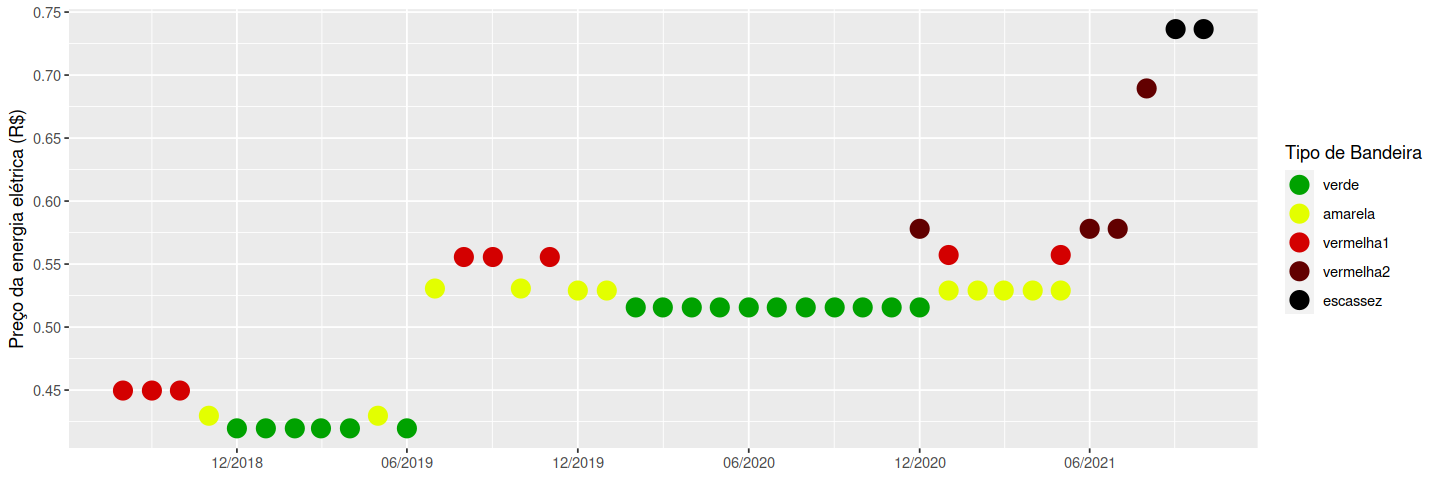

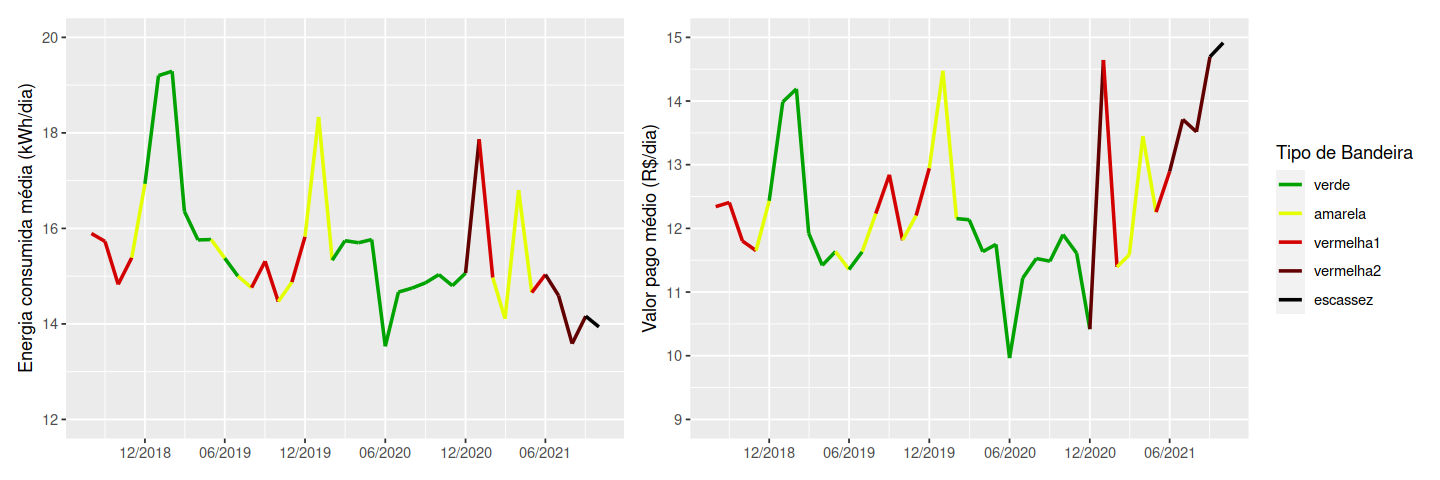

In [37]:
# Fonte: https://www.aneel.gov.br/resultado-dos-processos-tarifarios-de-distribuicao
tarifa_energia <- read.csv("./fontes/tarifa_energia.csv")

valor_bandeiras <- read.csv("./fontes/bandeiras.csv") %>%
    mutate(datas = as.Date(datas, format = "%d %m %Y")) %>%
    mutate(
        valores = case_when(
            format(.$datas, "%Y") == 2017 ~ .$valores + tarifa_energia$te[1] + tarifa_energia$tusd[1],
            format(.$datas, "%Y") == 2018 ~ .$valores + tarifa_energia$te[2] + tarifa_energia$tusd[2],
            format(.$datas, "%Y") == 2019 ~ .$valores + tarifa_energia$te[3] + tarifa_energia$tusd[3],
            format(.$datas, "%Y") == 2020 ~ .$valores + tarifa_energia$te[4] + tarifa_energia$tusd[4],
            format(.$datas, "%Y") == 2021 ~ .$valores + tarifa_energia$te[5] + tarifa_energia$tusd[5]
        )
    )

dias_bandeiras <- read.csv("./fontes/dias_bandeiras.csv") %>%
   mutate(data_referencia = as.Date(data_referencia, format = "%Y-%m-%d")) %>% # casting pra tipo Date
   rename(dias_medidos_bandeira = dias_medidos) %>% # mitigação de conflito no nome
   right_join(df, by = "data_referencia") %>% # fusão com o df principal
   mutate(tarifa_energia = 0) # aloca a coluna e a preenche com 0

for (i in c("verde", "amarela", "vermelha1", "vermelha2")) {
    data_ref <- dias_bandeiras$data_referencia[dias_bandeiras$tipos == i]
    intervalos <- valor_bandeiras$datas[valor_bandeiras$tipo == i]
    tarifas <- valor_bandeiras$valores[valor_bandeiras$tipo == i]
    dias_bandeiras$tarifa_energia[dias_bandeiras$tipos == i] <- case_when(
        data_ref < intervalos[2] ~ tarifas[1],
        between(data_ref, intervalos[2], intervalos[3]) ~ tarifas[2],
        between(data_ref, intervalos[3], intervalos[4]) ~ tarifas[3],
        between(data_ref, intervalos[4], intervalos[5]) ~ tarifas[4],
        TRUE ~ tarifas[5]
    )
}
dias_bandeiras$tarifa_energia[dias_bandeiras$tipos == "escassez"] <- valor_bandeiras$valores[valor_bandeiras$tipo == "escassez"]

bandeiras_nomes <- c("verde", "amarela", "vermelha1", "vermelha2", "escassez")
bandeiras_cores <- c("#00a200", "#e3ff00", "#d30000", "#620000", "#000000")

ggplot(
    dias_bandeiras,
    aes(
        x = data_referencia,
        y = tarifa_energia,
        color = tipos,
        group = 1
    )
    ) +
    geom_point(size = 5) +
    scale_color_manual(
        name = "Tipo de Bandeira",
        breaks = bandeiras_nomes,
        values = bandeiras_cores
    ) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Preço da energia elétrica (R$)",
        breaks = scales::breaks_extended(6)
    ) +
    labs(color = "Tipo de Bandeira")

fig7 <- ggplot(
    dias_bandeiras,
    aes(
        x = data_referencia,
        y = energia_medio,
        color = tipos,
        group = 1
    )
    ) +
    geom_line(size = 1) +
    scale_color_manual(
        name = "Tipo de Bandeira",
        breaks = bandeiras_nomes,
        values = bandeiras_cores
    ) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Energia consumida média (kWh/dia)",
        breaks = scales::breaks_extended(6),
        limits = c(12, 20)
    ) +
    theme(legend.position = "none")

fig8 <- ggplot(
    dias_bandeiras,
    aes(
        x = data_referencia,
        y = valor_medio,
        color = tipos,
        group = 1
    )
    ) +
    geom_line(size = 1) +
    scale_color_manual(
        name = "Tipo de Bandeira",
        breaks = bandeiras_nomes,
        values = bandeiras_cores
    ) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Valor pago médio (R$/dia)",
        breaks = scales::breaks_extended(6),
        limits = c(9, 15)
    ) +
    labs(color = "Tipo")

fig7 + fig8

Um indicador possível para ajudar no estabelecimento de metas é o da mudança das tarifas usadas no cálculo de consumo comparada ao ano anterior. Variação nos impostos sobre o serviço não foram considerados por mudarem menos que a TE e TUSD. Logo, se a bandeira tarifária de escassez hídrica continuar vigorando, é necessário que o consumo reduza pelo menos 6,8% — consumindo 367 kWh no mês ou 12,66 kWh/dia — para pagar o mesmo valor pago em Agosto de 2021. Caso a meta seja pagar o mesmo valor da conta de Novembro de 2020, então o consumo deve reduzir em 27% — consumindo 338 kWh no mês ou 11,66 kWh/dia.

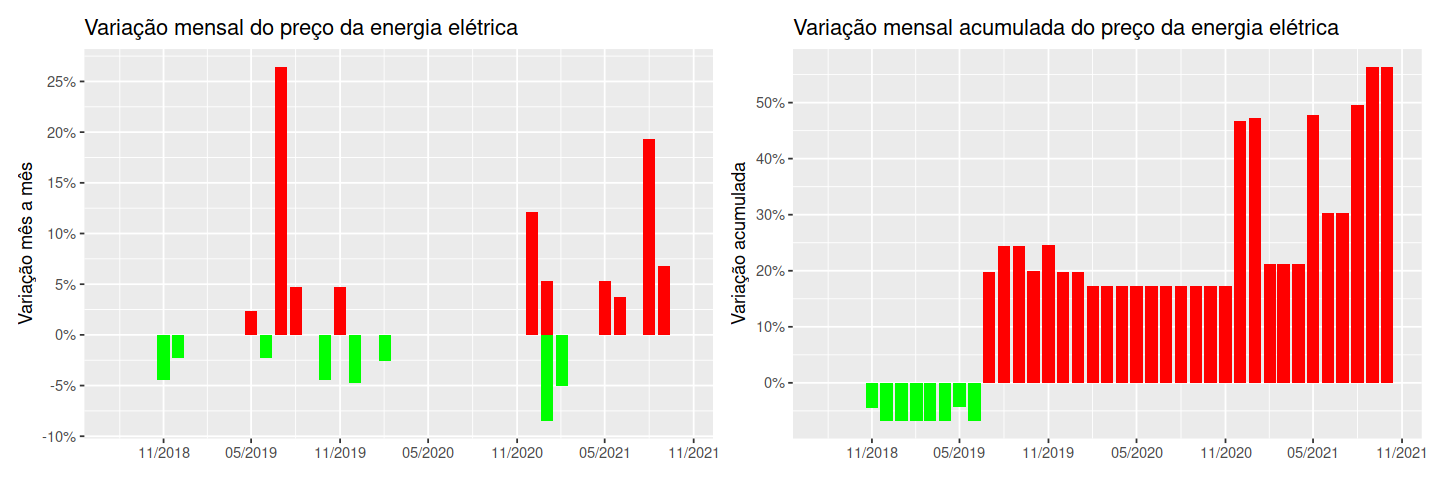

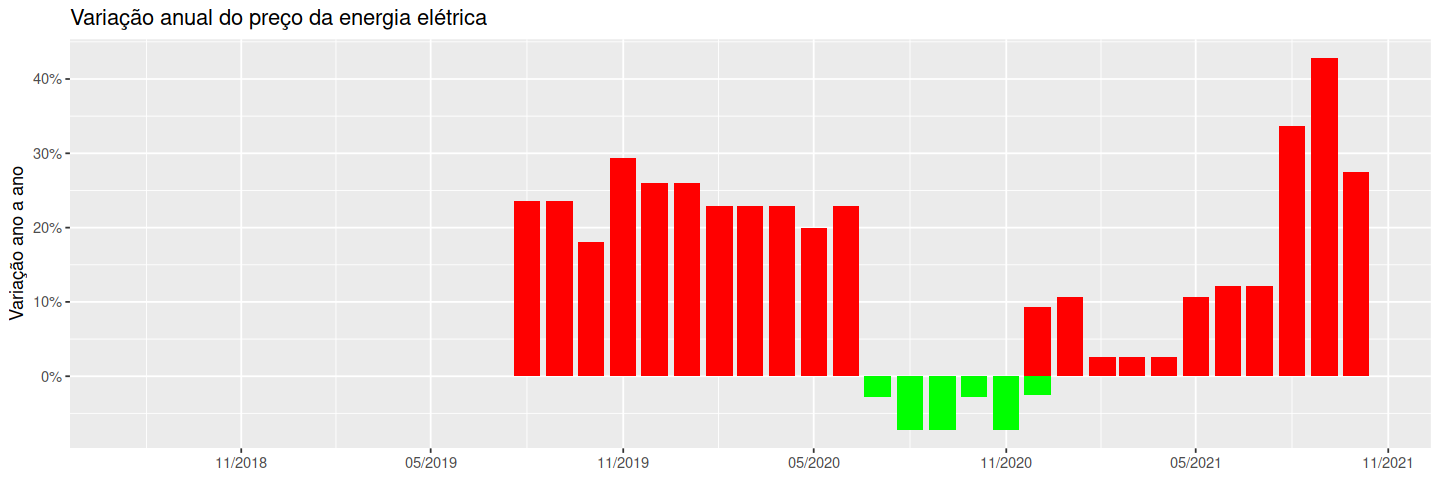

In [38]:
preco_energia_delta <- dias_bandeiras %>%
    select(data_referencia, tarifa_energia, tipos) %>%
    mutate(
        delta_mes = coalesce(tarifa_energia / lag(tarifa_energia) - 1, 0),
        delta_mes_acum = cumsum(coalesce(tarifa_energia / lag(tarifa_energia) - 1, 0)),
        delta_ano = coalesce(tarifa_energia / lag(tarifa_energia, 12) - 1, 0)
    ) %>%
    mutate(
        fill_mes = case_when(
            delta_mes < 0 ~ "n",
            delta_mes >= 0 ~ "p"
        ),
        fill_mes_acum = case_when(
            delta_mes_acum < 0 ~ "n",
            delta_mes_acum >= 0 ~ "p"
        ),
        fill_ano = case_when(
            delta_ano < 0 ~ "n",
            delta_ano >= 0 ~ "p"
        )
    )

fig9 <- ggplot(
    preco_energia_delta,
    aes(
        x = data_referencia,
        y = delta_mes,
        fill = fill_mes
    )
    ) +
    geom_col() +
    scale_fill_manual(values = c("n" = "green", "p" = "red")) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Variação mês a mês",
        breaks = scales::breaks_extended(8),
        labels = scales::percent_format(accuracy = 1)
    ) +
    theme(legend.position = "none") +
    labs(title = "Variação mensal do preço da energia elétrica")

fig10 <- ggplot(
    preco_energia_delta,
    aes(
        x = data_referencia,
        y = delta_mes_acum,
        fill = fill_mes_acum
    )
    ) +
    geom_col() +
    scale_fill_manual(values = c("n" = "green", "p" = "red")) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Variação acumulada",
        breaks = scales::breaks_extended(8),
        labels = scales::percent_format(accuracy = 1)
    ) +
    theme(legend.position = "none") +
    labs(title = "Variação mensal acumulada do preço da energia elétrica")

fig11 <- ggplot(
    preco_energia_delta,
    aes(
        x = data_referencia,
        y = delta_ano,
        fill = fill_ano
    )
    ) +
    geom_col() +
    scale_fill_manual(values = c("n" = "green", "p" = "red")) +
    scale_x_date(
        NULL,
        breaks = scales::breaks_width("6 months"),
        labels = scales::label_date("%m/%Y")
    ) +
    scale_y_continuous(
        "Variação ano a ano",
        breaks = scales::breaks_extended(8),
        labels = scales::percent_format(accuracy = 1)
    ) +
    theme(legend.position = "none") +
    labs(title = "Variação anual do preço da energia elétrica")

fig9 + fig10
fig11